In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import numpy as np
from enterprise import constants as const
import matplotlib.pyplot as plt
import corner

from settings import matplotsettings
matplotsettings()  # set all the standard matplotlib settings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/aaron/mambaforge/envs/enterprise/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


# Reproduce 12.5 year stochastic gravitational wave background search figures

* Here we reproduce figures 1 and 2 of the GWB search for the 12.5 year data
* NOTE: This file requires most of the chains to be downloaded before running!
* Download chains in `download_full_chains.ipynb`

## Common Process Spectral Model Comparison Plot (Figure 1)

In [2]:
## Definition for powerlaw and broken powerlaw for left side of Figure 1
def powerlaw(f, log10_A=-16, gamma=4.3333):
    return np.sqrt((10**log10_A)**2 / 12.0 / np.pi**2 * const.fyr**(gamma-3) * f**(-gamma) * f[0])

def Broken_powerlaw(f, log10_A=-16, gamma=4.3333, log10_fb=-8, delta=0, kappa=0.1):
    hcf = (10**log10_A) * (f / const.fyr) ** ((3-gamma) / 2) * (1 + (f / 10**log10_fb) ** (1/kappa)) ** (kappa * (gamma - delta) / 2)
    return np.sqrt(hcf**2 / 12 / np.pi**2 / f**3 * f[0])

# determine placement of frequency components
Tspan = 12.893438736619137 * (365 * 86400) #psr.toas.max() - psr.toas.min() #
freqs_30 = 1.0 * np.arange(1, 31) / Tspan
freqs_5 = 1.0 * np.arange(1, 6) / Tspan

### Import chains

In [7]:
# I did some thinning of my own since the chains were so massive
# This cell will take a minute to run

## broken power law

chain_DE438_bplaw_vary = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438_model2a_PSDbrokenplaw_gammaVary_chain.gz', usecols=np.arange(-7,-3), skiprows=25000)
chain_DE438_bplaw_vary = chain_DE438_bplaw_vary[::5]
pars_DE438_bplaw_vary = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438_model2a_PSDbrokenplaw_gammaVary_pars.txt', dtype=str)

## 5 frequency

chain_DE438_vary = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaVary_chain.gz', usecols=[90,91,92], skiprows=25000)
chain_DE438_vary = chain_DE438_vary[::4]

## 30 frequency

chain_DE438_30f_vary = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438_model2a_cRN30freq_gammaVary_chain.gz', usecols=[90,91,92], skiprows=25000)
chain_DE438_30f_vary = chain_DE438_30f_vary[::4]

## Free Spectral

chain_DE438_FreeSpec = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438_model2a_PSDspectrum_chain.gz', usecols=np.arange(90,120), skiprows=30000)
chain_DE438_FreeSpec = chain_DE438_FreeSpec[::5]

In [8]:
# Pull MLV params
DE438_vary_Bpl_idx = np.argmax(chain_DE438_bplaw_vary[:,-1])
DE438_vary_5cRN_idx = np.argmax(chain_DE438_vary[:,-1])
DE438_vary_30cRN_idx = np.argmax(chain_DE438_30f_vary[:,-1])

# Make MLV Curves
PL_5freq = powerlaw(freqs_5, log10_A=chain_DE438_vary[:,1][DE438_vary_5cRN_idx], gamma=chain_DE438_vary[:,0][DE438_vary_5cRN_idx])
PL_30freq = powerlaw(freqs_30, log10_A=chain_DE438_30f_vary[:,1][DE438_vary_30cRN_idx], gamma=chain_DE438_30f_vary[:,0][DE438_vary_30cRN_idx])
bPL = Broken_powerlaw(freqs_30, log10_A=chain_DE438_bplaw_vary[:,1][DE438_vary_Bpl_idx], log10_fb=chain_DE438_bplaw_vary[:,2][DE438_vary_Bpl_idx], gamma=chain_DE438_bplaw_vary[:,0][DE438_vary_Bpl_idx])

In [9]:
# Create an array for the bPL, 5f, and 30f chains
## (to be able to make the 1-sigma regions and plot mean curves)
bPL_num = int(chain_DE438_bplaw_vary[:,0].shape[0] / 5.)
bPL_array = np.zeros((bPL_num,30))
for ii in range(bPL_num):
    bPL_array[ii] = np.log10(Broken_powerlaw(freqs_30, log10_A=chain_DE438_bplaw_vary[ii*5,1], log10_fb=chain_DE438_bplaw_vary[ii*5,2], gamma=chain_DE438_bplaw_vary[ii*5,0]))

PL_5freq_num = int(chain_DE438_vary[:,0].shape[0] / 5.)
PL_5freq_array = np.zeros((PL_5freq_num,5))
for ii in range(PL_5freq_num):
    PL_5freq_array[ii] = np.log10(powerlaw(freqs_5, log10_A=chain_DE438_vary[ii*5,1], gamma=chain_DE438_vary[ii*5,0]))

PL_30freq_num = int(chain_DE438_30f_vary[:,0].shape[0] / 5.)
PL_30freq_array = np.zeros((PL_30freq_num,30))
for ii in range(PL_30freq_num):
    PL_30freq_array[ii] = np.log10(powerlaw(freqs_30, log10_A=chain_DE438_30f_vary[ii*5,1], gamma=chain_DE438_30f_vary[ii*5,0]))

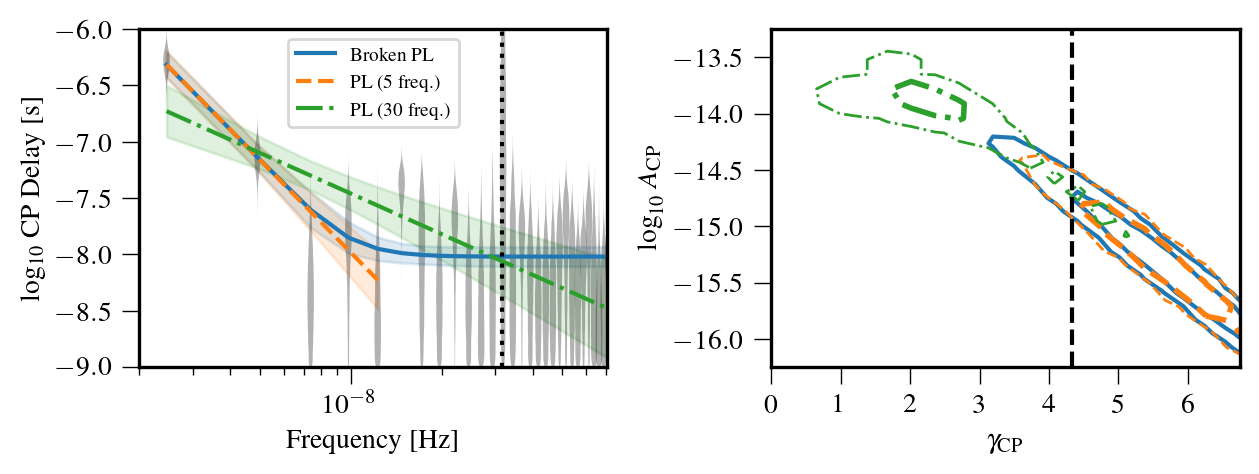

In [16]:
# Make Figure
plt.figure(figsize=[2*3.5503666805036667, 2.1942472810764047])

# Left Hand Side Of Plot
plt.subplot(1,2,1)

# Plot mean curves w/ 1-sigma regions
plt.semilogx(freqs_30, (bPL_array.mean(axis=0)), color='C0', label='Broken PL')
plt.fill_between(freqs_30, (bPL_array.mean(axis=0) - bPL_array.std(axis=0)), (bPL_array.mean(axis=0) + bPL_array.std(axis=0)), color='C0', alpha=0.15)

plt.semilogx(freqs_5, (PL_5freq_array.mean(axis=0)), color='C1', label='PL (5 freq.)', ls='dashed')
plt.fill_between(freqs_5, (PL_5freq_array.mean(axis=0) - PL_5freq_array.std(axis=0)), (PL_5freq_array.mean(axis=0) + PL_5freq_array.std(axis=0)), color='C1', alpha=0.15)

plt.semilogx(freqs_30, (PL_30freq_array.mean(axis=0)), color='C2', label='PL (30 freq.)', ls='dashdot')
plt.fill_between(freqs_30, (PL_30freq_array.mean(axis=0) - PL_30freq_array.std(axis=0)), (PL_30freq_array.mean(axis=0) + PL_30freq_array.std(axis=0)), color='C2', alpha=0.15)

# Plot Free Spectral Violin Plot
vpt = plt.violinplot(chain_DE438_FreeSpec, positions=(freqs_30), widths=0.05*freqs_30, showextrema=False)
for pc in vpt['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.3)

# Plot Labels
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'log$_{10}$ CP Delay [s]') # Residual [s]
plt.ylim(-9, -6)
plt.xlim(10**-8.7,10**-7.15)
plt.legend(loc=9)

# f = f_yr line
plt.axvline(3.17e-8, color='k', linestyle='dotted')

# Right Hand Plot
plt.subplot(1,2,2)

crn = corner.hist2d(chain_DE438_bplaw_vary[:,0], chain_DE438_bplaw_vary[:,1], color='C0', plot_datapoints=False, plot_density=False, levels=[0.67], countour_kwargs={'linewidths':2})
corner.hist2d(chain_DE438_bplaw_vary[:,0], chain_DE438_bplaw_vary[:,1], color='C0', plot_datapoints=False, plot_density=False, levels=[0.95], countour_kwargs={'linewidths':1}, ax=crn)

corner.hist2d(chain_DE438_vary[:,0], chain_DE438_vary[:,1], color='C1', plot_datapoints=False, plot_density=False, levels=[0.67], contour_kwargs={'linestyles':'dashed','linewidths':2}, ax=crn)
corner.hist2d(chain_DE438_vary[:,0], chain_DE438_vary[:,1], color='C1', plot_datapoints=False, plot_density=False, levels=[0.95], contour_kwargs={'linestyles':'dashed','linewidths':1}, ax=crn)

corner.hist2d(chain_DE438_30f_vary[:,0], chain_DE438_30f_vary[:,1], color='C2', plot_datapoints=False, plot_density=False, levels=[0.67], contour_kwargs={'linestyles':'dashdot','linewidths':2}, ax=crn)
corner.hist2d(chain_DE438_30f_vary[:,0], chain_DE438_30f_vary[:,1], color='C2', plot_datapoints=False, plot_density=False, levels=[0.95], contour_kwargs={'linestyles':'dashdot','linewidths':1}, ax=crn)

# gamma = 13/3 line
plt.axvline(13/3., color='k', linestyle='dashed')

# Plot Labels
plt.ylim(-16.25, -13.25)
plt.xlim(0,6.75)
plt.xticks([0,1,2,3,4,5,6])
plt.ylabel('$\log_{10}\, A_\mathrm{CP}$')
plt.xlabel(r'$\gamma_\mathrm{CP}$')

plt.subplots_adjust(wspace=0.35)
plt.show()

## Figure 2
* Note: The models labeled as such use the `INPOP19` ephemeris. This is changed up above when the data is imported (where we change `DE438` to `INPOP19`).

### Common process posteriors

In [19]:
## Fixed Ephemeris Chains
pars_fixed = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt', dtype=str)
chain_DE438 = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz', usecols=[90], skiprows=100000)
chain_INPOP19 = np.loadtxt('../../chains/downloaded_chains/12p5yr_INPOP19_model2a_cRN5freq_gammaFixed4.33_chain.gz', usecols=[90], skiprows=100000)

## BayesEphem w/SetIII Chains

pars_setIII = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438wBayesEphem_model2a_cRN5freq_gammaFixed4.33_pars.txt', dtype=str)
chain_DE438_s3 = np.loadtxt('../../chains/downloaded_chains/12p5yr_DE438wBayesEphem_model2a_cRN5freq_gammaFixed4.33_chain.gz', usecols=[95], skiprows=100000)
chain_INPOP19_s3 = np.loadtxt('../../chains/downloaded_chains/12p5yr_INPOP19wBayesEphem_model2a_cRN5freq_gammaFixed4.33_chain.gz', usecols=[95], skiprows=100000)


In [20]:
## Combine chains
gw_chains = []
gw_chains.append(chain_DE438_s3[100000::10])
gw_chains.append(chain_DE438[100000::10])
gw_chains.append(chain_INPOP19_s3[100000::10])
gw_chains.append(chain_INPOP19[100000::10])

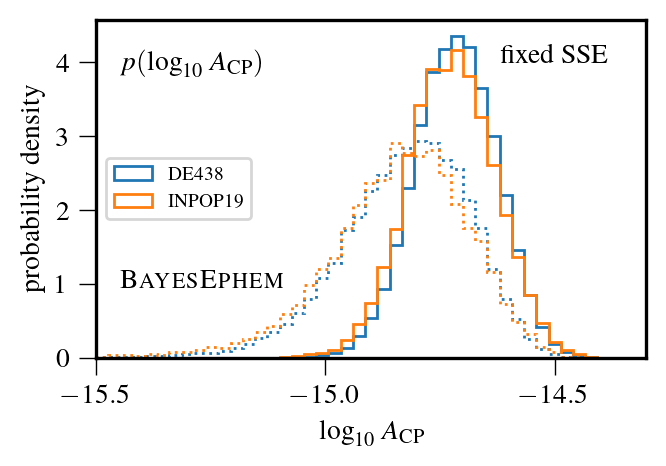

In [22]:
# Make Figure
# figsize(0.5)

agwrange = [-15.5,-14.3]
agwbins = 45

# Plot Posteriors
for i,eph in enumerate(['DE438','INPOP19']):
    plt.hist(gw_chains[2*i], histtype='step', density=True, bins=agwbins, range=agwrange,
            color="C%d"%(i), ls=':')

    plt.hist(gw_chains[(2*i)+1], histtype='step', density=True, bins=agwbins, range=agwrange,
            color="C%d"%(i), label=eph)

# Set Plot Axes
plt.axis(xmin=agwrange[0],xmax=agwrange[1])
plt.xticks([-15.5,-15,-14.5])
plt.xlabel('$\log_{10}\, A_\mathrm{CP}$')
plt.ylabel('probability density')

# Add text
plt.text(-15.45,3.9,'$p(\log_{10}\, A_\mathrm{CP})$')
plt.text(-14.5,4,'fixed SSE',ha='center')
plt.text(-15.27,0.95,r'$\textsc{BayesEphem}$',ha='center')

# Add legend
plt.legend(loc=6)

# plt.savefig('Figure2.png',bbox_inches='tight')
plt.show()